In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!cat SHE_Data_Analysis-6.py

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# In[39]:


#Semiconductor Dimensions
width = 10.0/100
length = 10.0/100
thickness = 1.25/1000
cross_area = width * thickness
I = 100e-6
q = 1.602e-19


# ## 2000 G B-field ##

# In[115]:


# Load the 2000G raw data file
df_2000G = pd.read_csv("2000G_100uA.csv", sep="\t", engine="python")

# Convert required columns to numeric
cols_to_convert = ["Temperature (K)", "Voltage AC", "Voltage BD", "B-Field (Gauss)"]
for col in cols_to_convert:
    df_2000G[col] = pd.to_numeric(df_2000G[col], errors="coerce")

# Drop rows with missing values in any of those columns
df_2000G = df_2000G.dropna(subset=cols_to_convert)

# Split the data into three B-field ranges
df2000_B_neg = df_2000G[df_2000G["B-Field (Gauss)"] < -1000].copy()
df2000_B_zero = df_2000G[(df_2000G["B-Field (Gauss)"] >= -1000) & (df_2000G["B-Field (Gauss)"] <= 1000)].copy()
df2000_B_pos = df_2000G[df_2000G["B-F

In [5]:
#Semiconductor Dimensions
width = 10.0/100
length = 10.0/100
thickness = 1.25/1000
cross_area = width * thickness
I = 100e-6
q = 1.602e-19

In [8]:
def analyze_hall_file(file_path, label="", 

    T = "Temperature (K)",
    B = "B-Field (Gauss)",
    curr_AB = "sample I AB", 
    curr_nAB = "sample I -AB", 
                      
    #longitudinal voltages
    V_DC = "Voltage DC",
    V_nDC = "Voltage -DC",
    
    #transverse voltages
    V_AC = "Voltage AC",
    V_nAC = "Voltage -AC",
    V_BD = "Voltage BD",
    V_nBD = "Voltage -BD",
    assume_whitespace_if_not_csv=True,
    zero_field_gauss=0.0,
    plot=True,
):
    fp = Path(file_path)
    # --- load ---
    if fp.suffix.lower() == ".csv":
        df = pd.read_csv(fp)
    else:
        df = pd.read_csv(fp, sep=r"\s+", engine="python") if assume_whitespace_if_not_csv else pd.read_csv(fp)
    
    # --- numeric conversion ---
    cols_to_convert = [T, B, curr_AB, curr_nAB, V_DC, V_nDC]
    cols_to_convert += [V_AC, V_nAC]
    for c in cols_to_convert:
        if c not in df.columns:
            raise KeyError(f"Required column missing: {c}")
        df[c] = pd.to_numeric(df[c], errors="coerce")
        
    # --- BD if it exists ---
    has_bd = (V_BD in df.columns) and (V_nBD in df.columns)
    if has_bd:
        df[V_BD] = pd.to_numeric(df[V_BD], errors="coerce")
        df[V_nBD] = pd.to_numeric(df[V_nBD], errors="coerce")
    else:
        print("⚠️ Note: BD pair not found; using AC only for Hall (still OK, just slightly less robust).")

    df = df.dropna(subset=[T, B, curr_AB, curr_nAB, V_DC, V_nDC, V_AC, V_nAC]).copy()
    df = df.sort_values(T).reset_index(drop=True)
    
#----------------------------------------------------------------------------------------------------------------#

    df["B_T"] = df[B]/1e4
    df["I_A"] = 0.5*(df[curr_AB].abs() + df[curr_nAB].abs())
    
    # --- voltage asymmetries ---
    df["Vxx"] = 0.5*(df[V_DC]+df[V_nDC])
    Vxy_AC = 0.5*(df[V_AC]-df[V_nAC])
    if has_bd:
        Vxy_BD = 0.5*(df[V_BD]-df[V_nBD])
        df["Vxy"] = 0.5(Vxy_AC + Vxy_BD)
        df["Vxy_AC"] = Vxy_AC
        df["Vxy_BD"] = Vxy_BD
    else:
        df["Vxy"] = Vxy_AC
        df["Vxy_AC"] = Vxy_AC
    
    #

In [74]:
# find resistivity, hall coefficient, accuracy, type of semiconductor, transition temp'

R_ABDC = df["Voltage DC"]/df["sample I AB"]
R_ADBC = (df["Voltage BC"])/(df["sample I AD"])

In [75]:
df.columns

Index(['Temperature (K)', 'B-Field (Gauss)', 'sample I AB', 'sample I AD',
       'sample I AC', 'sample I BD', 'sample I -AB', 'sample I -AD',
       'sample I -AC', 'sample I -BD', 'Voltage DC', 'Voltage BC',
       'Voltage BD', 'Voltage AC', 'Voltage -DC', 'Voltage -BC', 'Voltage -BD',
       'Voltage -AC'],
      dtype='object')

In [194]:
q=1.602e-19
d = 1e-3
gtt=1e-4
B=df['B-Field (Gauss)']*gtt
temp=np.array(df['Temperature (K)'])
f = lambda x: 1/(np.cosh(x/2.403))
rho = np.pi * d/np.log(2) * (R_ABDC + R_ADBC)/2 * f(R_ABDC/R_ADBC) #THIS IS RESISTIVITY in Ohm?

In [195]:
rho, 

(0      0.714403
 1      0.733905
 2      0.755325
 3      0.779507
 4      0.802425
          ...   
 163   -0.034373
 164   -0.038674
 165   -0.044813
 166   -0.049255
 167   -0.054147
 Length: 168, dtype: float64,)

Text(0, 0.5, 'resistivity (m * ohm)?')

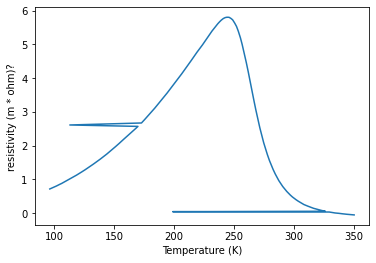

In [196]:
plt.plot(np.array(df['Temperature (K)']), np.array(rho))
plt.xlabel("Temperature (K)")
plt.ylabel("resistivity (m * ohm)?") # outliter here

In [197]:
#At room temp: 295.5K data point 133
voltBD=df["Voltage BD"][133]
volt_BD=df["Voltage -BD"][133]
BDVHall=(voltBD-volt_BD)/2
print('VHall is', BDVHall)
VBDHall = (df["Voltage BD"]-df["Voltage -BD"])/2 #Hall Voltage
IBDHall = df["sample I AC"][133]
df['Rhall'] = (BDVHall*d)/(IBDHall*B)
print('RHall is', df['Rhall'][133])
#RHall = (VBDHall*d)/(IBDHall*B)
#RHall

VHall is 0.00025375
RHall is 4.470578005637466


In [198]:
currden = 1/(q*Rhall)
ty = df['Rhall'].apply(lambda x: 'p-type semiconductor' if x > 0 else 'n-type semiconductor')
typ = ty[133]
print(currden, typ)

1.3962841595788516e+18 p-type semiconductor


Text(0, 0.5, 'Hall Coeff')

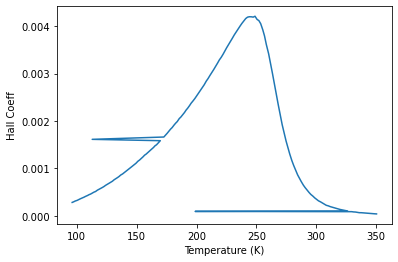

In [199]:
plt.plot(np.array(df['Temperature (K)']), np.array(RHall))
plt.xlabel("Temperature (K)")
plt.ylabel("Hall Coeff")

Text(0, 0.5, 'Hall Coeff')

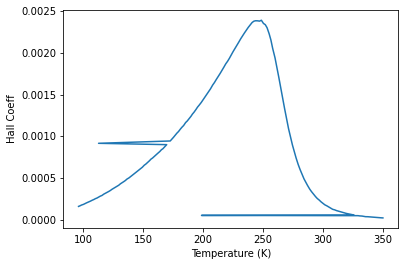

In [200]:
plt.plot(np.array(df['Temperature (K)']), np.array(VBDHall))
plt.xlabel("Temperature (K)")
plt.ylabel("Hall Coeff")

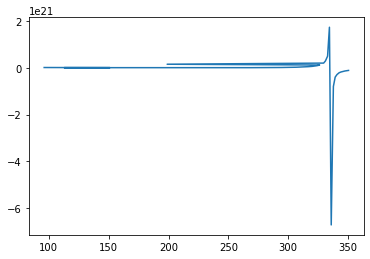

In [201]:
mobil = 1/(rho*q)
plt.plot(np.array(df['Temperature (K)']), np.array(mobil))

Text(0, 0.5, 'Hall Coeff')

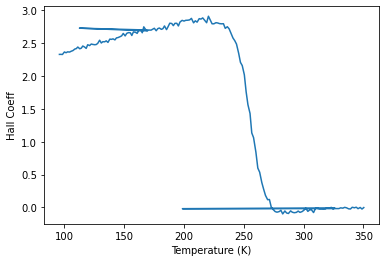

In [229]:
VBDHall = (df["Voltage BD"]-df["Voltage -BD"])/2 #Hall Voltage
#VHall = df["Voltage BD"]
IACHall = df["sample I AC"]
RHall1 = (VBDHall*d)/(IACHall*B)

VACHall = (df["Voltage AC"]-df["Voltage -AC"])/2 #Hall Voltage
IBDHall = df["sample I BD"]
RHall2 = (VACHall*d)/(IBDHall*B)

V = -(VBDHall+VACHall)/2
R = (V*d)/(IBDHall*B)

plt.plot(np.array(temp), np.array(R))
#plt.plot(np.array(temp), np.array(RHall1))
#plt.plot(np.array(temp), np.array(RHall2))
#plt.plot(np.array(RHall1), np.array(VBDHall))
plt.xlabel("Temperature (K)")
plt.ylabel("Hall Coeff")

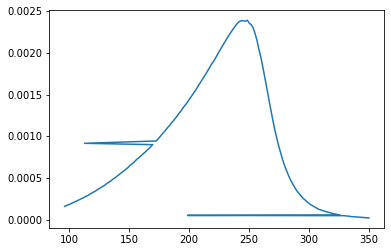

In [214]:
plt.plot(np.array(temp), np.array(VBDHall))